# Inaugural Project

> **Note the following:** 
> 1. This is an example of how to structure your **inaugural project**.
> 1. Remember the general advice on structuring and commenting your code
> 1. The `inauguralproject.py` file includes a function which can be used multiple times in this notebook.

Imports and set magics:

In [348]:
import numpy as np

# autoreload modules when code is run. Otherwise, python will not see recent changes. 
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.optimize import minimize_scalar
plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"--"})
plt.rcParams.update({'font.size': 14})
from Exchange import ExchangeEconomyClass
model = ExchangeEconomyClass()

# Imports the model variables 
par = model.par

# Total endowment
w1bar = 1.0
w2bar = 1.0

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Question 1

The initial endowment is:
$$\omega_1^A=0.8$$
$$\omega_2^A=0.3$$

Now we illustrate the set C (the Pareto improvements relative to the endowment) in the Edgeworth box

In [332]:
# Define endowment points
wA1 = 0.8
wA2 = 0.3
wB1 = 1 - wA1
wB2 = 1 - wA2

In [331]:
# Define the grid for x_A1 and x_A2
N = 75
x_A1_values = [i/N for i in range(N+1)]
x_A2_values = [i/N for i in range(N+1)]

In [333]:
# Initialize list to store Pareto improvements
pareto_improvements = []

# Iterate over combinations
for x_A1 in x_A1_values:
    for x_A2 in x_A2_values:
        x_B1 = 1 - x_A1
        x_B2 = 1 - x_A2
        
        # Check if the combination is a Pareto improvement
        if (model.utility_A(x_A1, x_A2) >= model.utility_A(wA1, wA2) and
            model.utility_B(x_B1, x_B2) >= model.utility_B(wB1, wB2)):
            pareto_improvements.append((x_A1, x_A2))

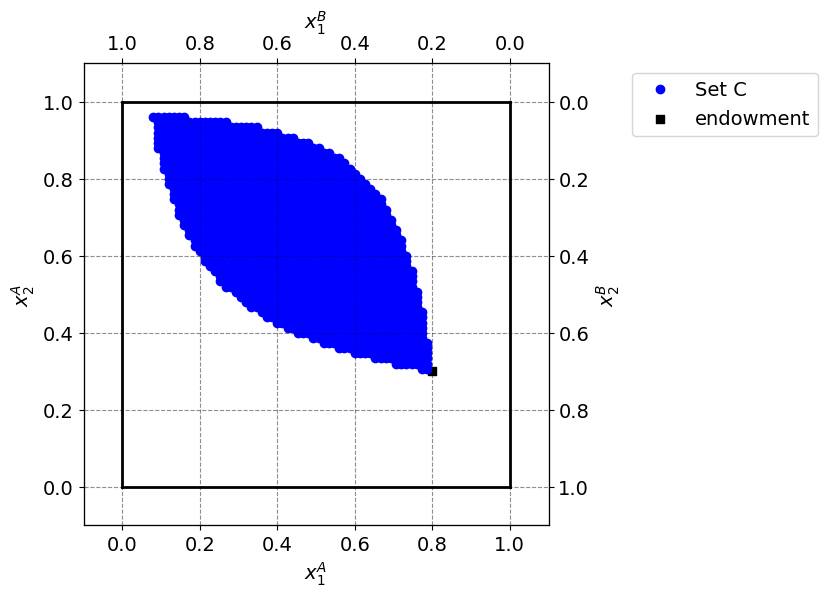

In [334]:

# Figure set up
fig = plt.figure(frameon=False,figsize=(6,6), dpi=100)
ax_A = fig.add_subplot(1, 1, 1)

ax_A.set_xlabel("$x_1^A$")
ax_A.set_ylabel("$x_2^A$")

temp = ax_A.twinx()
temp.set_ylabel("$x_2^B$")
ax_B = temp.twiny()
ax_B.set_xlabel("$x_1^B$")
ax_B.invert_xaxis()
ax_B.invert_yaxis()

# Extract x_A1 and x_A2 from pareto_improvements
pareto_improvements_x_A1 = [allocation[0] for allocation in pareto_improvements]
pareto_improvements_x_A2 = [allocation[1] for allocation in pareto_improvements]

# Plot the set C
ax_A.plot(pareto_improvements_x_A1, pareto_improvements_x_A2, 'bo', label='Set C')

# A
ax_A.scatter(par.w1A,par.w2A,marker='s',color='black',label='endowment')

# Limits
ax_A.plot([0,w1bar],[0,0],lw=2,color='black')
ax_A.plot([0,w1bar],[w2bar,w2bar],lw=2,color='black')
ax_A.plot([0,0],[0,w2bar],lw=2,color='black')
ax_A.plot([w1bar,w1bar],[0,w2bar],lw=2,color='black')

ax_A.set_xlim([-0.1, w1bar + 0.1])
ax_A.set_ylim([-0.1, w2bar + 0.1])    
ax_B.set_xlim([w1bar + 0.1, -0.1])
ax_B.set_ylim([w2bar + 0.1, -0.1])

ax_A.legend(frameon=True,loc='upper right',bbox_to_anchor=(1.6,1.0));


# Question 2

For the price set $p_1$ we calculate the error in the market clearing conditions:

In [336]:
# Define the grid for p1 and p2
N = 75
P1 = [0.5+2*i/N for i in range(N+1)]
p2 = 1  # Numeraire is p2 = 1

In [335]:
# Initialize lists to store errors
errors_1 = []
errors_2 = []

# Calculate the error in the market clearing conditions eps1 and eps2 for each price
for p1 in P1:
    eps1, eps2 = model.check_market_clearing(p1)
    errors_1.append(eps1)
    errors_2.append(eps2)


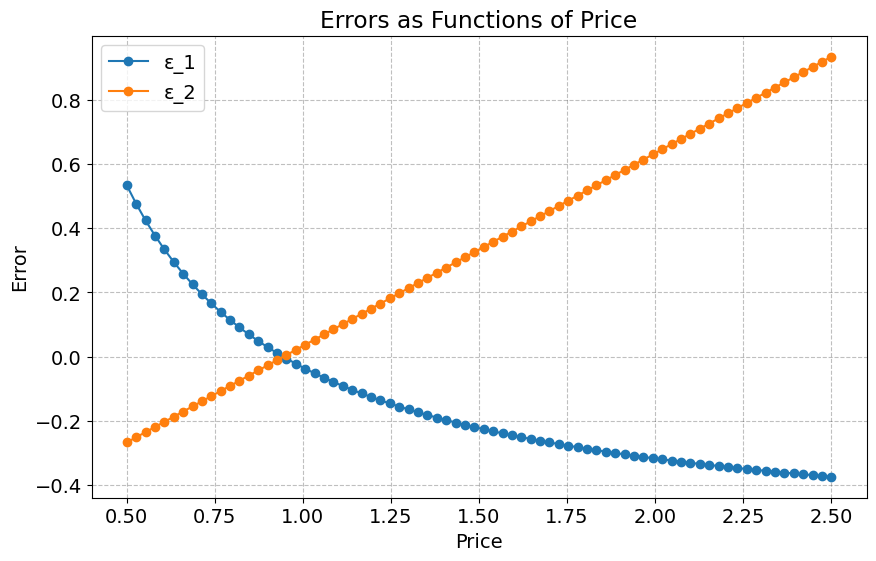

In [341]:
 # Plotting errors
plt.figure(figsize=(10, 6))
plt.plot(P1, errors_1, label='ε_1', marker='o')
plt.plot(P1, errors_2, label='ε_2', marker='o')

# Adding labels and title
plt.xlabel('Price')
plt.ylabel('Error')
plt.title('Errors as Functions of Price')
plt.legend()

#Display the plot
plt.show()


# Question 3

Calculating the market clearing price:

In [355]:
from scipy.optimize import root_scalar

# We define a function that calculates the difference between eps1 and eps2 for a given p1
def market_clearing_equation(p1):
    eps1, eps2 = model.check_market_clearing(p1) 
    return eps1 - eps2 

# Find the root of the market clearing equation where eps1 - eps2 = 0
result = root_scalar(market_clearing_equation, bracket=[0.1, 1])

# Check if the root finding was successful
p1_market_clearing = result.root

print("The market clearing price(p1) is: " + str(p1_market_clearing))



The market clearing price(p1) is: 0.9444444444444442


# Question 4a

Assuming that A chooses the price to maximize own utility, we can find the allocation if only prices in $P_1$ can be chosen:

In [340]:

# Define the utility function
def u_A(x_B1, x_B2, alpha):
    return (1-x_B1) ** alpha * (1-x_B2) ** (1 - alpha)

alpha = 1/3
beta = 2/3

# Initialize variables to store the optimal allocation and utility
optimal_x_A1 = 0
optimal_x_A2 = 0
max_utility = float('-inf')
optimal_p1 = None

# Loop through all possible allocations of x_B1 and x_B2
for p1 in P1:
    x_B1 = beta * (p1 * wB1 + wB2) / p1
    x_B2 = (1 - beta) * (p1 * wB1 +  wB2)
    
    # Ensure that x_B1 and x_B2 are between 0 and 1
    if 0 <= x_B1 <= 1 and 0 <= x_B2 <= 1:
        current_utility = u_A(x_B1, x_B2, alpha)
        # Check if current allocation gives higher utility
        if current_utility > max_utility:
            max_utility = current_utility
            optimal_x_A1 = 1- x_B1
            optimal_x_A2 = 1- x_B2
            optimal_p1 = p1

# Print the results
print("Optimal allocation of x_A1:", optimal_x_A1)
print("Optimal allocation of x_A2:", optimal_x_A2)
print("Optimal p1:", optimal_p1)
print("Maximum Utility for A:", max_utility)

Optimal allocation of x_A1: 0.619316843345112
Optimal allocation of x_A2: 0.6408888888888888
Optimal p1: 1.8866666666666667
Maximum Utility for A: 0.633615985237553


# Question 4b

The allocation if any positive price can be chosen: 

In [339]:
# Define the negative utility function to maximize
def negative_utility_A(p1):
    if p1 <= 0:
        return float('inf')  # Return positive infinity to avoid p1 being zero
    xB1, xB2 = model.demand_B(p1)
    return -model.utility_A(1 - xB1, 1 - xB2)

# Find the maximum utility for the given price
result = minimize_scalar(negative_utility_A, method='golden')  # Set a minimum bound for p1

# Check if optimization was successful
if result.success:
    optimal_p1 = result.x
    max_uA = -result.fun  # Since we minimized negative utility, maximum utility is -result.fun
    xB1_opt, xB2_opt = model.demand_B(optimal_p1)
    x1A_4b = 1 - xB1_opt
    x2A_4b = 1 - xB2_opt
    uA_4b = max_uA
    uB_4b = model.utility_B(1 - x1A_4b, 1 - x2A_4b)
    
    print("Optimal p1(4b):", optimal_p1)
    print("Utility for consumer A:", uA_4b)
    print("Utility for consumer B:", uB_4b)
    print("Allocation for consumer A:")
    print("x1A =", x1A_4b) 
    print("x2A =", x2A_4b) 
    print("Allocation for consumer B:")
    print("x1B =", xB1_opt) 
    print("x2B =", xB2_opt) 
    
else:
    print("Optimization failed:", result.message)



Optimal p1(4b): 1.8993463017872192
Utility for consumer A: 0.6336208506936609
Utility for consumer B: 0.37256365374199035
Allocation for consumer A:
x1A = 0.6209680985711333
x2A = 0.6400435798808521
Allocation for consumer B:
x1B = 0.37903190142886667
x2B = 0.3599564201191479


c:\Users\pwarr\Programmering\Lib\site-packages\scipy\optimize\_optimize.py:2973: RuntimeWarning: invalid value encountered in scalar divide
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom


# Question 5a

Assuming that A chooses B's consumption, while B cant not be worse of than endowment. we can find the allocation that maximizes A's utility if the choice set is restricted to $C$:

In [342]:
# Define the utility function
def u_A(x_A1, x_A2, alpha):
    return (x_A1) ** alpha * (x_A2) ** (1 - alpha)

# Initialize variables to store the optimal allocation and utility
optimal_allocation = None
max_utility_A = float('-inf')

# Iterate over combinations
for x_A1 in x_A1_values:
    for x_A2 in x_A2_values:
        # Calculate x_B1 and x_B2
        x_B1 = 1 - x_A1
        x_B2 = 1 - x_A2
        
        # Check if the allocation satisfies the constraints
        if 0 <= x_A1 <= 1 and 0 <= x_A2 <= 1 and 0 <= x_B1 <= 1 and 0 <= x_B2 <= 1:
            # Calculate utilities for A and B
            utility_A = u_A(x_A1, x_A2, alpha)
            utility_B = u_B(x_B1, x_B2, beta)
            
            # Check if B's utility is not worse than endowment
            if utility_B >= u_B(omega_B1, omega_B2, beta):
                # Check if this allocation maximizes A's utility
                if utility_A > max_utility_A:
                    max_utility_A = utility_A
                    optimal_allocation = (x_A1, x_A2, x_B1, x_B2)

# Print the optimal allocation and utilities
if optimal_allocation is not None:
    print("Optimal allocation:")
    print("x_A1 =", optimal_allocation[0])
    print("x_A2 =", optimal_allocation[1])
    print("x_B1 =", optimal_allocation[2])
    print("x_B2 =", optimal_allocation[3])
    print("Utility for A:", max_utility_A)
    print("Utility for B:", u_B(optimal_allocation[2], optimal_allocation[3], beta))
else:
    print("No feasible allocation found.")


Optimal allocation:
x_A1 = 0.56
x_A2 = 0.8533333333333334
x_B1 = 0.43999999999999995
x_B2 = 0.1466666666666666
Utility for A: 0.7415523509091093
Utility for B: 0.30507896071427915


# Question 5b

Allocation if no further restrictions are imposed:

In [338]:
# Define the negative utility function to maximize
def negative_utility_A(allocation):
    xA1, xA2 = allocation
    return -model.utility_A(xA1, xA2)

# Define the constraint for agent B's utility
def constraint_B_utility(allocation):
    xA1, xA2 = allocation
    xB1, xB2 = 1 - xA1, 1 - xA2
    return model.utility_B(xB1, xB2) - model.utility_B(wB1,wB2)

# Initial guess for the allocation (taken from solution to 5a)
initial_guess = [0.56 ,0.853]

# Define the bounds for the allocation (both xA1 and xA2 should be between 0 and 1)
bounds = [(0, 1), (0, 1)]

# Define the constraint in the form required by `minimize`
constraints = {'type': 'ineq','fun': constraint_B_utility}

# Perform the optimization
result = minimize(negative_utility_A, initial_guess, bounds=bounds, constraints=constraints)

# Check if optimization was successful
if result.success:
    x1A_5b, x2A_5b = result.x
    x1B_5b = 1 - x1A_5b
    x2B_5b = 1 - x2A_5b 
    uA_5b = model.utility_A(x1A_5b, x2A_5b)
    uB_5b = model.utility_B(1 - x1A_5b, 1 - x2A_5b)
    optimal_allocation = (x1A_5b, x2A_5b, x1B_5b, x2B_5b)

    print("Optimal allocation:")
    print("x_A1 =", optimal_allocation[0])
    print("x_A2 =", optimal_allocation[1])
    print("x_B1 =", optimal_allocation[2])
    print("x_B2 =", optimal_allocation[3])
    print("Utility for A:", max_utility_A)
    print("Utility for B:", model.utility_B(optimal_allocation[2], optimal_allocation[3]))
else:
    print("Optimization failed:", result.message)


Optimal allocation:
x_A1 = 0.5757577936064096
x_A2 = 0.8444284564815401
x_B1 = 0.42424220639359045
x_B2 = 0.15557154351845992
Utility for A: 0.7415523509091093
Utility for B: 0.30365886802291453


# Question 6a

We now assume that A's and B's consumption are chosen by a utilitarian social planner, and we find the allocation that maximizes the aggregate utility: 

In [351]:
# Define the negative aggregate utility function to maximize
def negative_aggregate_utility(allocation):
    xA1, xA2 = allocation
    xB1, xB2 = 1 - xA1, 1 - xA2
    uA = model.utility_A(xA1, xA2)
    uB = model.utility_B(xB1, xB2)
    return -(uA + uB)

# Initial guess for the allocation (could be the initial endowment)
initial_guess = [0.5 , 0.5]

# Define the bounds for the allocation (both xA1 and xA2 should be between 0 and 1)
bounds = [(0, 1), (0, 1)]

# Perform the optimization
result = minimize(negative_aggregate_utility, initial_guess, bounds=bounds)

# Check if optimization was successful
if result.success:
    x1A_6a, x2A_6a = result.x
    x1B_6a, x2B_6a = 1 - x1A_6a, 1 - x2A_6a
    uA_6a = -result.fun
    uB_6a = model.utility_B(x1B_6a, x2B_6a)
    optimal_allocation = (x1A_6a, x2A_6a, x1B_6a, x2B_6a)
    
    print("Optimal allocation:")
    print("x_A1 =", optimal_allocation[0])
    print("x_A2 =", optimal_allocation[1])
    print("x_B1 =", optimal_allocation[2])
    print("x_B2 =", optimal_allocation[3])
    print("Aggregate utility:", uA_6a+uB_6a)
    print("Utility for A:", uA_6a)
    print("Utility for B:", uB_6a)
else:
    print("Optimization failed:", result.message)


Optimal allocation:
x_A1 = 0.3333333659693852
x_A2 = 0.6666666260640767
x_B1 = 0.6666666340306149
x_B2 = 0.3333333739359233
Aggregate utility: 1.5874010561835585
Utility for A: 1.0582673679787966
Utility for B: 0.5291336882047618


# Question 6b

Comparing the results from the previous exercises:

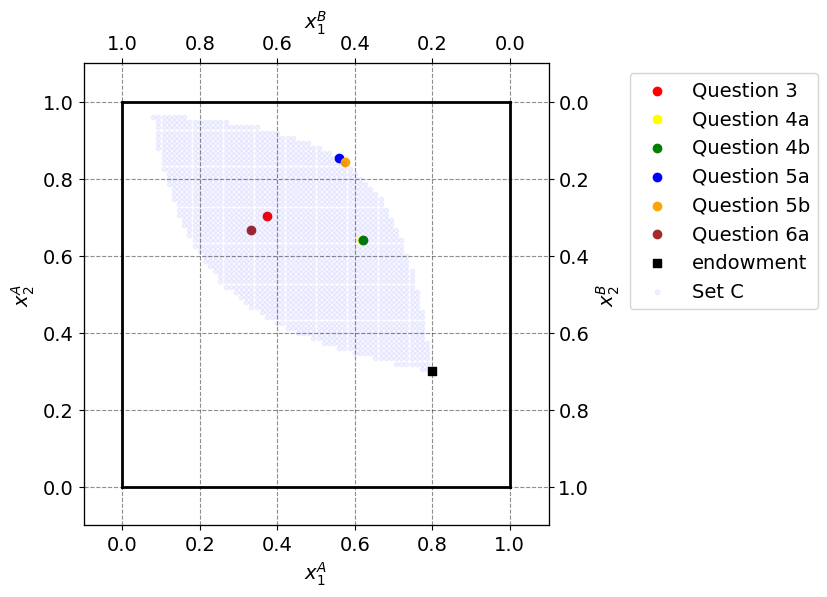

In [353]:

import matplotlib.pyplot as plt
plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"--"})
plt.rcParams.update({'font.size': 14})


from Exchange import ExchangeEconomyClass


model = ExchangeEconomyClass()


par = model.par

# a. total endowment
w1bar = 1.0
w2bar = 1.0

# b. figure set up
fig = plt.figure(frameon=False,figsize=(6,6), dpi=100)
ax_A = fig.add_subplot(1, 1, 1)

ax_A.set_xlabel("$x_1^A$")
ax_A.set_ylabel("$x_2^A$")

temp = ax_A.twinx()
temp.set_ylabel("$x_2^B$")
ax_B = temp.twiny()
ax_B.set_xlabel("$x_1^B$")
ax_B.invert_xaxis()
ax_B.invert_yaxis()


opgave_3x_A1 = 0.37254902
opgave_3x_A2 = 0.703703704
opgave_4ax_A1 = 0.619316843345112
opgave_4ax_A2 = 0.6408888888888888
opgave_4bx_A1 = 0.6209680985711333
opgave_4bx_A2 = 0.6400435798808521
opgave_5ax_A1 = 0.56
opgave_5ax_A2 = 0.8533333333333334
opgave_5bx_A1 = 0.5757577936064096
opgave_5bx_A2 = 0.8444284564815401
opgave_6ax_A1 = 0.3333333659693852
opgave_6ax_A2 = 0.6666666260640767

ax_A.scatter(opgave_3x_A1,opgave_3x_A2, marker='o',color='red',label='Question 3')
ax_A.scatter(opgave_4ax_A1,opgave_4ax_A2, marker='o',color='yellow',label='Question 4a')
ax_A.scatter(opgave_4bx_A1,opgave_4bx_A2, marker='o',color='green',label='Question 4b')
ax_A.scatter(opgave_5ax_A1,opgave_5ax_A2, marker='o',color='blue',label='Question 5a')
ax_A.scatter(opgave_5bx_A1,opgave_5bx_A2, marker='o',color='orange',label='Question 5b')
ax_A.scatter(opgave_6ax_A1,opgave_6ax_A2, marker='o',color='brown',label='Question 6a')
# A
ax_A.scatter(par.w1A,par.w2A,marker='s',color='black',label='endowment')
ax_A.scatter(pareto_improvements_x_A1, pareto_improvements_x_A2, s=10, color='blue', alpha=0.05, label='Set C')

# limits
ax_A.plot([0,w1bar],[0,0],lw=2,color='black')
ax_A.plot([0,w1bar],[w2bar,w2bar],lw=2,color='black')
ax_A.plot([0,0],[0,w2bar],lw=2,color='black')
ax_A.plot([w1bar,w1bar],[0,w2bar],lw=2,color='black')

ax_A.set_xlim([-0.1, w1bar + 0.1])
ax_A.set_ylim([-0.1, w2bar + 0.1])    
ax_B.set_xlim([w1bar + 0.1, -0.1])
ax_B.set_ylim([w2bar + 0.1, -0.1])

ax_A.legend(frameon=True,loc='upper right',bbox_to_anchor=(1.6,1.0));



**Discussion of the different allocations:**

The plot above shows the different allocations plotted in the same edgeworth box. 
We see that the allocation from (3) is almost the same as the social planner allocation from (6a). 
Since an efficient market economy will deliver an optimal alocation this makes sense, and the only 
friction between the allocations is caused by the discrete jumps in the set P1.
The allocation from (4a) and (4b) is almost identical which again makes sense as the optimal price is included in P1.
Loosening the constraint from prices only in the set P1 to all positive prices therefore only makes a difference due to the the discrete nature of the set P1.
The allocation from (5a) and (5b) favours consumer A more strongly as seen by the comparisons of utility below. 
This is due to the fact that A can choose the consumption of B directly, thereby getting a more favourable allocation.

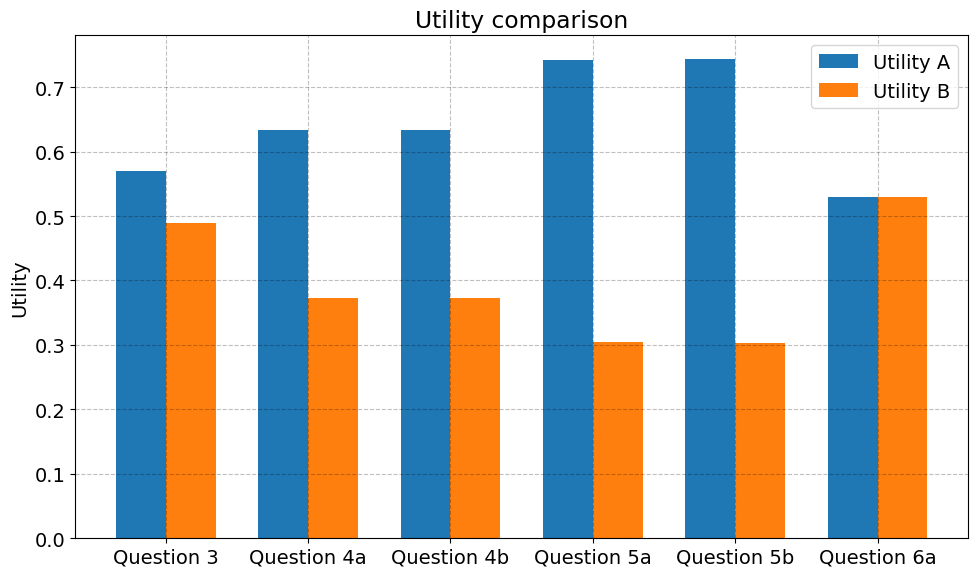

In [352]:
import matplotlib.pyplot as plt
import numpy as np

# Define the allocation results from questions 3)-6)
allocations = {
    'Question 3': {'x_A1': 0.37254902, 'x_A2': 0.703703704, 'x_B1': 0.62745098, 'x_B2': 0.296296296},
    'Question 4a': {'x_A1': 0.619316843345112, 'x_A2': 0.640888888, 'x_B1': (1-0.619316843345112), 'x_B2': (1-0.640888888)},
    'Question 4b': {'x_A1': 0.6209680985711333, 'x_A2': 0.6400435798808521, 'x_B1': (1-0.6209680985711333), 'x_B2': (1-0.6400435798808521)},
    'Question 5a': {'x_A1': 0.56, 'x_A2': 0.8533333333333334, 'x_B1': 0.44, 'x_B2': (1-0.8533333333333334)},
    'Question 5b': {'x_A1': 0.5757577936064096, 'x_A2': 0.8444284564815401, 'x_B1': (1-0.5757577936064096), 'x_B2': (1-0.8444284564815401)},
    'Question 6a': {'x_A1': 0.3333333659693852, 'x_A2': 0.6666666260640767, 'x_B1': (1-0.3333333659693852), 'x_B2': (1-0.6666666260640767)}
}

# Plot utility values
utility_A = []
utility_B = []
labels = []

for label, allocation in allocations.items():
    x_A1, x_A2, x_B1, x_B2 = allocation.values()
    utility_A.append(x_A1 ** (1/3) * x_A2 ** (2/3))
    utility_B.append(x_B1 ** (2/3) * x_B2 ** (1/3))
    labels.append(label)

fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

rects1 = ax.bar(x - width/2, utility_A, width, label='Utility A')
rects2 = ax.bar(x + width/2, utility_B, width, label='Utility B')

ax.set_ylabel('Utility')
ax.set_title('Utility comparison')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.tight_layout()

plt.show()

# Question 7

Drawing $W$ with 50 elements:

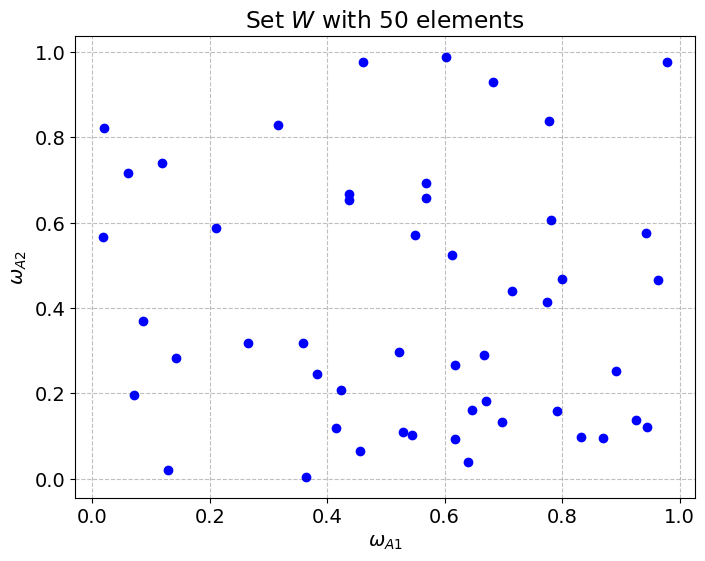

In [354]:
import numpy as np
import matplotlib.pyplot as plt

# Set the random seed for reproducibility
np.random.seed(0)

# Number of elements in the set W
num_elements = 50

# Generate random values for omega_A1 and omega_A2
wA1_values = np.random.uniform(0, 1, num_elements)
wA2_values = np.random.uniform(0, 1, num_elements)

# Plot the set W
plt.figure(figsize=(8, 6))
plt.scatter(wA1_values, wA2_values, color='blue')
plt.title('Set $W$ with 50 elements')
plt.xlabel('$\omega_{A1}$')
plt.ylabel('$\omega_{A2}$')
plt.grid(True)
plt.show()


The plot above shows the distribution of the 50 random endowments for consumer A. Each point represents an allocation of endowments for consumer A, that is an endowment of good 1 and good 2. Indirectly, this also defines the endowments for consumber B, as these are just 1-$W^A_i$ for i=1,2. 

# Question 8

Set W (Endowments for Agent A of Good 1 and Good 2, and Endowments for Agent B of Good 1 and Good 2):
[[0.31179588 0.69634349 0.68820412 0.30365651]
 [0.37775184 0.17960368 0.62224816 0.82039632]
 [0.02467873 0.06724963 0.97532127 0.93275037]
 [0.67939277 0.45369684 0.32060723 0.54630316]
 [0.53657921 0.89667129 0.46342079 0.10332871]
 [0.99033895 0.21689698 0.00966105 0.78310302]
 [0.6630782  0.26332238 0.3369218  0.73667762]
 [0.020651   0.75837865 0.979349   0.24162135]
 [0.32001715 0.38346389 0.67998285 0.61653611]
 [0.58831711 0.83104846 0.41168289 0.16895154]
 [0.62898184 0.87265066 0.37101816 0.12734934]
 [0.27354203 0.79804683 0.72645797 0.20195317]
 [0.18563594 0.95279166 0.81436406 0.04720834]
 [0.68748828 0.21550768 0.31251172 0.78449232]
 [0.94737059 0.73085581 0.05262941 0.26914419]
 [0.25394164 0.21331198 0.74605836 0.78668802]
 [0.51820071 0.02566272 0.48179929 0.97433728]
 [0.20747008 0.42468547 0.79252992 0.57531453]
 [0.37416998 0.46357542 0.62583002 0.53642458]
 [0.2

C:\Users\pwarr\AppData\Local\Temp\ipykernel_6384\3332572569.py:80: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  p1_solution = fsolve(market_clearing_condition, p1_guess)
C:\Users\pwarr\AppData\Local\Temp\ipykernel_6384\3332572569.py:80: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  p1_solution = fsolve(market_clearing_condition, p1_guess)
C:\Users\pwarr\AppData\Local\Temp\ipykernel_6384\3332572569.py:26: RuntimeWarning: invalid value encountered in power
  return x1**alpha_A * x2**(1-alpha_A)
C:\Users\pwarr\AppData\Local\Temp\ipykernel_6384\3332572569.py:35: RuntimeWarning: invalid value encountered in power
  return x1**alpha_B * x2**(1-alpha_B)
C:\Users\pwarr\AppData\Local\Temp\ipykernel_6384\3332572569.py:26: RuntimeWarning: invalid value encountered in scalar power
  return x1**alpha_A * x2**(1-alpha_A)
C:\Users\pw

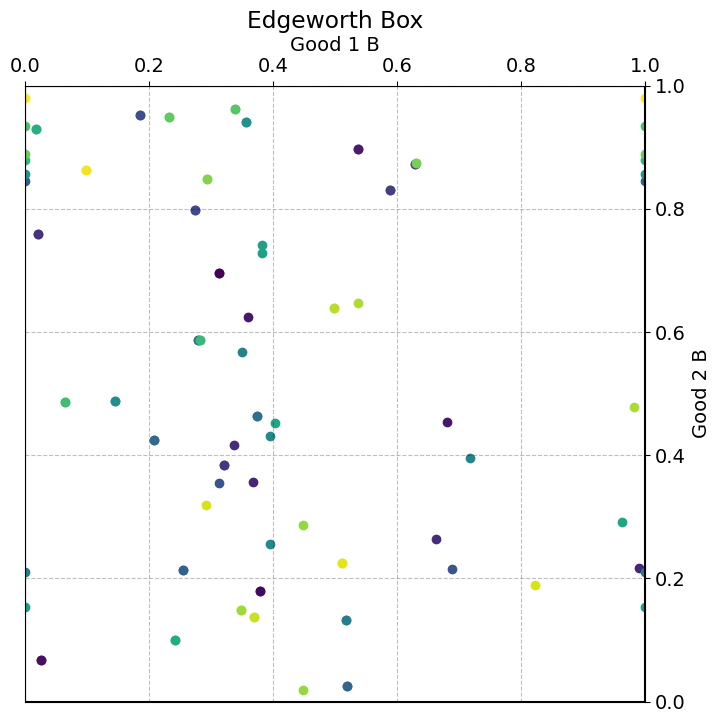

In [343]:
import numpy as np

# Set the number of vectors
num_samples = 50

# Generate random endowment vectors for agent A
endowments_A = np.random.rand(num_samples, 2)

# Calculate endowments for agent B
endowments_B = 1 - endowments_A

# Combine endowments for agent A and agent B into a single set W
endowments_W = np.concatenate((endowments_A, endowments_B), axis=1)

# Print the set W
print("Set W (Endowments for Agent A of Good 1 and Good 2, and Endowments for Agent B of Good 1 and Good 2):")
print(endowments_W)

# Given parameters
alpha_A = 1/3
alpha_B = 2/3
price_good2 = 1  # Price of good 2

# Utility and demand functions for agent A
def utility_A(x1, x2):
    return x1**alpha_A * x2**(1-alpha_A)

def demand_A(p1, p2, omega_A1, omega_A2):
    x1 = alpha_A * omega_A1 / p1
    x2 = (1 - alpha_A) * omega_A2 / p2
    return x1, x2

# Utility and demand functions for agent B
def utility_B(x1, x2):
    return x1**alpha_B * x2**(1-alpha_B)

def demand_B(p1, p2, omega_B1, omega_B2):
    x1 = alpha_B * omega_B1 / p1
    x2 = (1 - alpha_B) * omega_B2 / p2
    return x1, x2

# Market allocation function for both agents
def market_allocation(p1, p2, omega_A1, omega_A2):
    x1_A, x2_A = demand_A(p1, p2, omega_A1, omega_A2)
    x1_B, x2_B = demand_B(p1, p2, 1 - omega_A1, 1 - omega_A2)  # Endowments for agent B are 1 - endowments for agent A
    
    # Ensure total amount of each good is 1
    total_good1 = x1_A + x1_B
    total_good2 = x2_A + x2_B
    scaling_factor = 1 / max(total_good1, total_good2)
    x1_A *= scaling_factor
    x1_B *= scaling_factor
    x2_A *= scaling_factor
    x2_B *= scaling_factor
    
    # Ensure utility for each agent is at least the same as in the original endowment
    if utility_A(x1_A, x2_A) < utility_A(omega_A1, omega_A2):
        x1_A, x2_A = omega_A1, omega_A2
    if utility_B(x1_B, x2_B) < utility_B(1 - omega_A1, 1 - omega_A2):
        x1_B, x2_B = 1 - omega_A1, 1 - omega_A2

    return x1_A, x2_A, x1_B, x2_B

# Solve for market allocations for each endowment vector in set W
market_allocations = []
for endowment in endowments_W:
    # Set p2 = 1
    p2 = 1
    
    # Initial guess for p1
    p1_guess = 1
    
    # Define the market clearing condition function
    def market_clearing_condition(p1):
        x1_A, x2_A, _, _ = market_allocation(p1, p2, endowment[0], endowment[1])
        return x1_A + endowment[0] - 1  # Market clearing condition
    
    # Solve for p1 using fsolve
    from scipy.optimize import fsolve
    p1_solution = fsolve(market_clearing_condition, p1_guess)
    
    # Calculate market allocation using the solved p1
    x1_A, x2_A, x1_B, x2_B = market_allocation(p1_solution[0], p2, endowment[0], endowment[1])
    
    # Append market allocation to the list
    market_allocations.append([x1_A, x2_A, x1_B, x2_B])

# Convert market allocations to NumPy array
market_allocations = np.array(market_allocations)

import matplotlib.pyplot as plt
import numpy as np

# Extract market allocations for each agent
x1_A = market_allocations[:, 0]
x2_A = market_allocations[:, 1]
x1_B = market_allocations[:, 2]
x2_B = market_allocations[:, 3]

# Determine the number of vectors
num_vectors = len(x1_A)

# Generate a colormap with a color for each vector
colors = plt.cm.viridis(np.linspace(0, 1, num_vectors))

# Plotting Edgeworth box
plt.figure(figsize=(8, 8))
plt.xlabel("Good 1 A")
plt.ylabel("Good 2 A")
plt.title("Edgeworth Box")

# Plot market allocations for agent A
for i in range(num_vectors):
    plt.scatter(x1_A[i], x2_A[i], color=colors[i], label=f'Agent A - Vector {i}')

# Plot market allocations for agent B (inverted axes)
for i in range(num_vectors):
    plt.scatter(1 - x1_B[i], 1 - x2_B[i], color=colors[i], label=f'Agent B - Vector {i}')

# Set axis limits to ensure axes go from 0 to 1
plt.xlim(0, 1)
plt.ylim(0, 1)

# Plot axes
plt.plot([0, 1], [0, 0], color='black')  # x-axis
plt.plot([0, 0], [0, 1], color='black')  # y-axis
plt.plot([1, 1], [0, 1], color='black')  # Second x-axis for Agent B
plt.plot([0, 1], [1, 1], color='black')  # Second y-axis for Agent B

# Add right and top axes
plt.gca().yaxis.set_label_position("right")
plt.gca().xaxis.set_label_position("top")
plt.gca().yaxis.tick_right()
plt.gca().xaxis.tick_top()
plt.xlabel("Good 1 B")
plt.ylabel("Good 2 B")

plt.grid(True)
plt.show()
